This notebook shows how to download a dataset of drought-induced tree mortality for California. The data were generated by rasterizing damage polygons from the US Forest Service's Aerial Detection Survey program. Other covariates were generated with Google Earth Engine. For details on this process, see github.com/s-kganz/forestlst. The license at that repository applies to this data too. Much of this workflow is adapted from [Preisler et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0378112717304772).

**Get the data**

Data are distributed across files with one year per file. We can use a wildcard expression to pull all the years of data and merge them together.

In [1]:
import pandas as pd

alldata = pd.read_csv("https://storage.googleapis.com/drought-table/preisler_dim_allyears.csv")

Each row describes one 4 km pixel for one year in California from 1999 to 2018. The variables are as follows:

 - `elev`: Elevation above sea level in meters
 - `fire`: Proportion of pixel where wildfires burned that year
 - `latitude`: Latitude of the pixel center in decimal degrees
 - `longitude`: Longitude of the pixel center in decimal degrees
 - `mort`: Proportion of pixel where forest mortality of any severity was observed
 - `near`: Highest value of `mort` among neighboring pixels in the same year
 - `prcp`: Water-year (Oct of `year-1` to Oct of `year`) precipitation in mm
 - `rhost`: Proportion of pixel with forest cover minus `mort` in the previous year
 - `rwc`: SAR-derived summer median relative water content after [Rao et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0034425719301208).
 - `tmin`: Minimum air temperature from Dec of `year-1` to Feb of `year`
 - `year`: Year of observation

In [2]:
alldata.describe()

,Unnamed: 0,elev,fire,latitude,longitude,mort,near,prcp,rhost,rwc,tmin,year
count,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000,305370.000000
mean,152684.500000,1303.270783,0.023833,38.577064,-120.746418,0.033068,0.096016,890.434095,0.609584,0.481069,-6.847528,2010.156456
std,88152.870189,766.687703,0.152530,2.390281,1.906977,0.111545,0.191194,574.062383,0.403451,0.169081,5.493595,4.982501
min,0.000000,-8.000000,0.000000,32.567223,-124.237004,0.000000,0.000000,0.000000,0.000000,-0.460538,-38.072500,1999.000000
25%,76342.250000,700.000000,0.000000,36.934637,-122.368508,0.000000,0.000000,445.753747,0.107449,0.361022,-10.785000,2006.000000
50%,152684.500000,1264.000000,0.000000,38.918471,-120.787473,0.000000,0.006400,766.938748,0.808041,0.484713,-5.815000,2010.000000
75%,229026.750000,1767.000000,0.000000,40.657817,-119.242371,0.004000,0.088800,1211.563124,0.973054,0.597517,-2.387500,2014.000000
max,305369.000000,3914.000000,1.000000,42.006813,-115.074188,1.000000,1.000000,4567.319967,1.000000,1.293637,5.891667,2018.000000


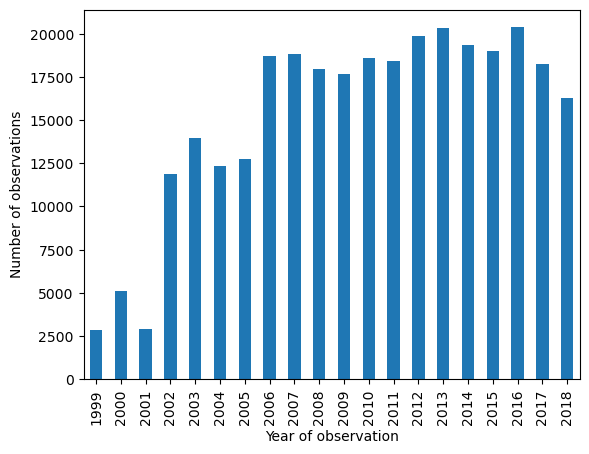

In [3]:
from matplotlib import pyplot as plt
alldata.year.value_counts(sort=False).plot(kind="bar")
plt.ylabel("Number of observations")
plt.xlabel("Year of observation")
plt.show()

The `year`, `latitude`, and `longitude` columns give us coordinates to create an xarray dataset from this CSV. This lets us do mapping and make use of the xarray API.

In [4]:
import xarray as xr
import rioxarray
import rasterio

# Have to write a CRS and rename lat/lon to make rasterio happy
alldata_xr = alldata.set_index(["latitude", "longitude", "year"])\
    .to_xarray()\
    .rename(latitude="y", longitude="x")\
    .rio.write_crs(4326)
alldata_xr

<xarray.Dataset> Size: 125MB
Dimensions:      (y: 340, x: 256, year: 20)
Coordinates:
  * y            (y) float64 3kB 32.57 32.6 32.63 32.66 ... 41.95 41.98 42.01
  * x            (x) float64 2kB -124.2 -124.2 -124.2 ... -115.1 -115.1 -115.1
  * year         (year) int64 160B 1999 2000 2001 2002 ... 2015 2016 2017 2018
    spatial_ref  int64 8B 0
Data variables:
    Unnamed: 0   (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    elev         (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    fire         (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    mort         (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    near         (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    prcp         (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    rhost        (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    rwc          (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan
    tmin         (y, x, year) float64 14MB nan nan nan nan ... nan nan nan nan

Now we can quickly plot mortality over the years.

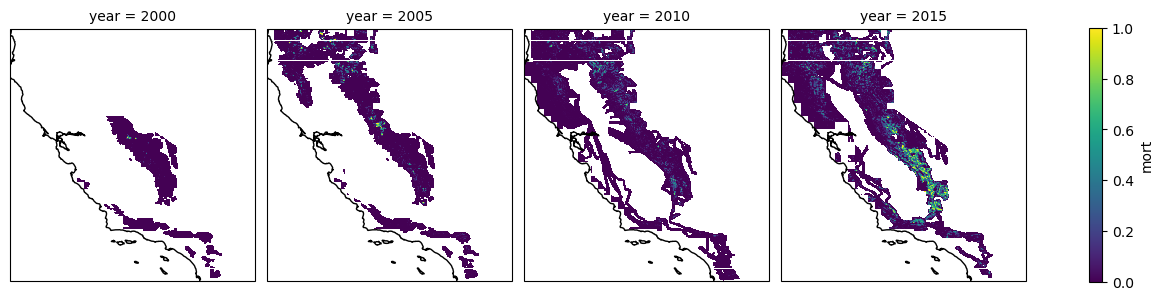

In [5]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

f = alldata_xr.sel(year=[2000, 2005, 2010, 2015]).mort.plot(
    col="year",
    subplot_kws=dict(projection=ccrs.PlateCarree())
)
[ax.coastlines() for ax in f.axs.flatten()]
plt.show()

We can see that data coverage varies depending on where the forest service did aerial detection surveys in a given year. We can also see that 2010 - 2015 was a particularly bad period for mortality. Let's plot mean mortality over time.

Text(0, 0.5, 'Geometric mean mortality')

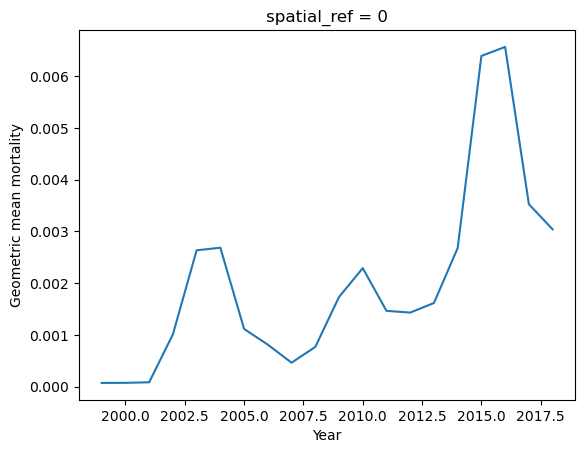

In [6]:
import numpy as np

mean_mort = (np.exp(np.log(alldata_xr.mort + 0.001).mean(dim=["x", "y"])) - 0.001).plot()
plt.xlabel("Year")
plt.ylabel("Geometric mean mortality")

Given the axis scale, you can see that most pixels experience no mortality at all.

One particularly powerful application of xarray is creating rolling windows. This is useful when we want to inclue spatial or temporal autocorrelation in a machine learning model. In this example, we slice out 3x3 windows in space and 5-year windows in time. Note that this operation is very memory intensive!

In [7]:
def do_windowing(df_xr, x_window, y_window, year_window):
    windowed = df_xr.rolling(x=x_window, y=y_window, year=year_window)\
        .construct(x="x_window", y="y_window", year="year_window")\

    # Squeeze out dimensions of size 1
    squeeze_dims = [x for x,y in windowed.sizes.items() if y == 1]
    stack_dims   = [x for x,y in windowed.sizes.items() if y >  1]
    
    return windowed\
        .squeeze(squeeze_dims)\
        .to_stacked_array("band", sample_dims=stack_dims, name="input")\
        .stack(sample=["x", "y", "year"])\
        .dropna(dim="sample", how="any")\
        .transpose("sample", "year_window", ..., "band")

In [ ]:
stacked = do_windowing(alldata_xr, 3, 3, 5)
stacked

Now each object along the `sample` dimension is a tensor of shape (5, 3, 3, 9) that we can pass to a deep learning model.

In [ ]:
stacked.isel(sample=0).values.shape

There are a few other details to consider if you want to use this dataset. If you are forecasting mortality, you need to shift mortality back a year so that the values in `mort` correspond to `year+1`. Also, your data need to be shuffled across space and time when you pass it to a model.